# Ejercicio 1: Preparación de ambiente de trabajo

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('default_credit.csv').drop(columns='index')

In [3]:
df

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


In [4]:
df.columns

Index(['default', 'student', 'balance', 'income'], dtype='object')

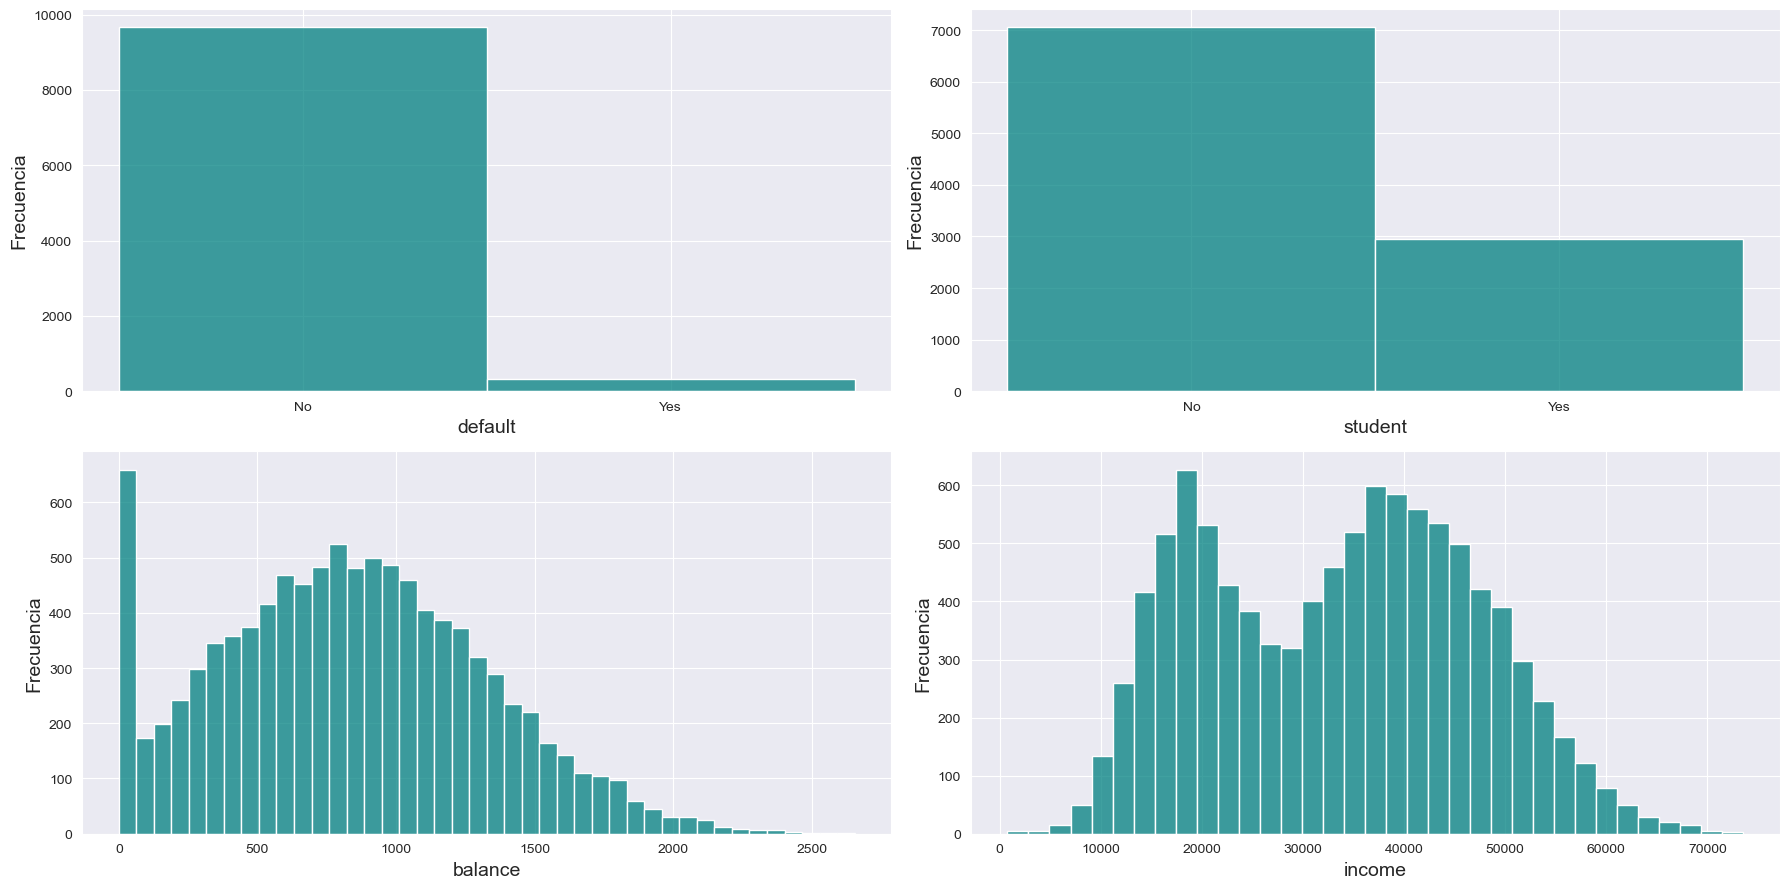

In [5]:
plt.figure(figsize=(18, 9))
for index, value in enumerate(df.columns):
    plt.subplot(2, 2, index + 1)
    sns.histplot(x=df[value], color='teal', stat='count')
    plt.xlabel(value, fontsize=14)  
    plt.ylabel("Frecuencia", fontsize=14)
    
plt.tight_layout()

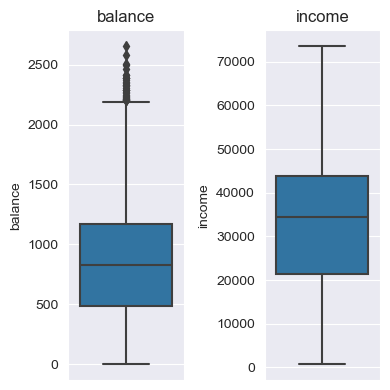

In [6]:
variables = ['balance', 'income']
fig, axs = plt.subplots(ncols=len(variables), figsize=(4, 4))
for i, var in enumerate(variables):
    sns.boxplot(y=df[var], ax=axs[i])
    axs[i].set_title(var)
plt.tight_layout()

    Se observa que el vector objetivo 'default' y la clase 'student' están muy desbalanceadas.
    
    El desbalance en las clases puede causar problemas al entrenar modelos, ya que algunos pueden tener dificultades para predecir correctamente la clase minoritaria debido a que hay menos datos de entrenamiento disponibles.

    Más adelante se realizará un oversampling utilizando SMOTE. Esta técnica de sobremuestreo sintético sirve para equilibrar el conjunto de datos desbalanceado generando nuevas instancias de la clase minoritaria. Esto puede ayudar a mejorar el desempeño de los modelos de aprendizaje en situaciones de clases desbalanceadas.

    En el caso de las otras dos clases, se observa que en 'balance' existe una gran cantidad de outliers. En ambos casos hay una gran varianza.


# Ejercicio 2: Modelo base

In [7]:
# instanciamos el objeto
lbl = LabelEncoder()

# Implementamos el método fit_transform para actualizar y sobreescribir cada columna de atributos
df['default'] = lbl.fit_transform(df['default']) # 1 indica yes
df['student'] = lbl.fit_transform(df['student']) # 1 indica yes

In [8]:
df

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
...,...,...,...,...
9995,0,0,711.555020,52992.378914
9996,0,0,757.962918,19660.721768
9997,0,0,845.411989,58636.156984
9998,0,0,1569.009053,36669.112365


In [9]:
X_train_pre, X_test_pre, y_train, y_test = train_test_split(df.drop('default', axis=1), df['default'],
                                                                    test_size=.33, random_state=94)

In [10]:
scaler = StandardScaler().fit(X_train_pre)
X_train = pd.DataFrame(scaler.transform(X_train_pre), columns=X_train_pre.columns)
X_test = pd.DataFrame(scaler.transform(X_test_pre), columns=X_test_pre.columns)

In [11]:
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

    Métricas de evaluación

In [12]:
lda_class_pred = lda_model.predict(X_test) 

In [13]:
print(classification_report(y_test, lda_class_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3199
           1       0.82      0.28      0.41       101

    accuracy                           0.98      3300
   macro avg       0.90      0.64      0.70      3300
weighted avg       0.97      0.98      0.97      3300



    Todos los puntajes para la clase 0 (no morosos) son altos, lo que significa que el modelo predice de manera correcta esta clase.
    
    El recall para la clase 1 es muy bajo, apenas 28%. Este valor indica que el modelo tiene una gran cantidad de falsos negativos (FN), lo que significa que hay muchas personas morosas que el modelo está pasando por alto.

    El valor de f1-score para la clase 1 es de 0.41, lo que indica que el modelo tiene un desempeño bajo en la identificación de personas morosas en comparación con la clase de no morosos. El f1-score es una métrica que combina precision y recall en una sola medida, y es útil para evaluar el equilibrio entre ambas medidas.

    En general, el bajo f1-score de la clase de morosos sugiere que el modelo necesita ser mejorado para identificar con mayor precisión a las personas morosas en el conjunto de datos. Si el banco se basa únicamente en esta métrica para tomar decisiones de gestión de riesgos, podría estar subestimando el riesgo crediticio y otorgando crédito a personas que pueden no ser capaces de pagar.

    En resumen, el modelo tiene un desempeño sobresaliente en la identificación de personas no morosas, lo que es una buena noticia para el banco en términos de gestión de riesgos crediticios. Sin embargo, el modelo tiene un desempeño mediocre en la identificación de personas morosas, lo que indica que se necesitan mejoras en el modelo para identificar con mayor precisión a las personas que presentan riesgo de no pago.

# Ejercicio 3: Refactorización 1 - información a priori

### Asumamos que hay un 50/50 de morosos y no morosos.

In [14]:
lda_model_50_50 = LinearDiscriminantAnalysis(priors=[.5, .5])
lda_model_50_50.fit(X_train, y_train)
lda_model_50_50_pred = lda_model_50_50.predict(X_test)
print(classification_report(y_test, lda_model_50_50_pred))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3199
           1       0.15      0.94      0.26       101

    accuracy                           0.84      3300
   macro avg       0.58      0.89      0.59      3300
weighted avg       0.97      0.84      0.89      3300



### Asumamos que hay un 60/40 de morosos y no morosos.

In [15]:
lda_model_60_40 = LinearDiscriminantAnalysis(priors=[.6, .4])
lda_model_60_40.fit(X_train, y_train)
lda_model_60_40_pred = lda_model_60_40.predict(X_test)
print(classification_report(y_test, lda_model_60_40_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93      3199
           1       0.18      0.88      0.30       101

    accuracy                           0.88      3300
   macro avg       0.59      0.88      0.62      3300
weighted avg       0.97      0.88      0.91      3300



    En ambos supuestos, ahora es el valor de precision el que es bajo.
    La precisión para la clase 1 (morosos) es baja, con un valor de 0.15 y 0.18 para ambos modelos. Esto indica que de todas las predicciones que el modelo ha hecho para la clase 1, solo el 15% y 18% son verdaderos positivos (personas que realmente son morosos). El resto de las predicciones son falsos positivos, lo que significa que los modelos están identificando erróneamente a muchas personas como morosos cuando en realidad no lo son.

    Por lo tanto, se puede concluir que ambos modelos tienen dificultades para identificar correctamente a los morosos en la muestra, y es probable que se necesiten mejoras en los modelos o en los datos de entrada para mejorar su capacidad para identificar correctamente a los morosos.

# Ejercicio 4: Refactorización 2 - oversampling

In [16]:
# from imblearn.over_sampling import SMOTE

# Instanciamos la clase
oversampler = SMOTE(random_state=94, sampling_strategy='minority')
# generamos el oversampling de los datos de entrenamiento
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train, y_train)

In [17]:
# Creamos un modelo lda
lda_model_smote = LinearDiscriminantAnalysis()

# Entrenamos el modelo con los datos de entrenamiento aumentados de forma artificial
lda_model_smote.fit(X_train_oversamp, y_train_oversamp)

# Evaluamos el desempeño del modelo en los datos de prueba
y_hat_smote = lda_model_smote.predict(X_test)
print(classification_report(y_test, y_hat_smote))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3199
           1       0.16      0.94      0.27       101

    accuracy                           0.84      3300
   macro avg       0.58      0.89      0.59      3300
weighted avg       0.97      0.84      0.89      3300



In [19]:
X_train_oversamp.shape

(12936, 3)

In [20]:
y_train_oversamp.shape

(12936,)

    Comparando los resultados antes y después de implementar la técnica de sobremuestreo SMOTE, se puede concluir lo siguiente:

    La precisión de la clase no morosa (clase 0) aumentó del 98% al 100%, lo que significa que se identificaron correctamente todos los clientes no morosos. Por otro lado, la precisión de la clase morosa (clase 1) disminuyó significativamente del 82% al 16%, lo que indica que ahora se están clasificando erróneamente la mayoría de los clientes morosos como no morosos.

    El recall de la clase morosa (clase 1) mejoró significativamente después de implementar la técnica de sobremuestreo SMOTE, pasando del 28% al 94%. Esto significa que el modelo ahora es mucho mejor para identificar correctamente a los clientes morosos, lo que podría ser muy importante para el banco, ya que identificar correctamente a los clientes morosos puede ayudarles a tomar medidas para reducir el riesgo de incumplimiento de préstamos o créditos, y por lo tanto, reducir las pérdidas financieras.
    Sin embargo, este aumento en el recall se produjo a costa de una disminución significativa en la precisión y el F1-score de la misma clase. Por lo tanto, es importante considerar el trade-off entre recall y precisión antes de implementar técnicas como SMOTE.

    En general, se puede decir que la implementación de SMOTE logró aumentar el recall de la clase morosa, es decir, identificar mejor a los clientes morosos, pero a costa de una disminución significativa en la precisión y el F1-score de la misma clase. Por lo tanto, antes de implementar SMOTE, es importante considerar si se prefiere tener un modelo más preciso o si es más importante identificar correctamente a los clientes morosos.

# Ejercicio 5: Refactorización 3 - QDA

In [21]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis().fit(X_train_oversamp, y_train_oversamp)
qda_class_pred = qda_model.predict(X_test)
print(classification_report(y_test, qda_class_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      3199
           1       0.17      0.93      0.28       101

    accuracy                           0.85      3300
   macro avg       0.58      0.89      0.60      3300
weighted avg       0.97      0.85      0.90      3300



    Podemos ver que ambos modelos tienen una precisión muy baja en la clasificación de la clase 1, lo que significa que tienen una alta tasa de falsos positivos para la clase morosa. Esto sugiere que se está clasificando erróneamente una gran cantidad de casos como morosos, cuando en realidad no lo son.

    Si comparamos ambos modelos, el primer modelo tiene un mejor desempeño en términos de recall, ya que tiene una puntuación ligeramente más alta que el segundo modelo. Sin embargo, ambos modelos tienen un rendimiento similar en términos de accuracy y f1-score.

    En resumen, ambos modelos tienen una buena capacidad predictiva para detectar a los clientes morosos, pero aún es necesario mejorar la precisión para disminuir los falsos positivos.
